In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import control as ct
import scienceplots

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 12 
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
#Dados da planta:
degma = np.loadtxt('degma.txt')            #tempo  angulo  ref usig
degma = [(degma[:, 0]-degma[0][0]), degma[:, 1], degma[:, 2], degma[:, 3]]

In [3]:
class FANPLATE():
    def __init__(self, La, Ra, kaphi, Jm, Bm1, Bm2, Bm3, ku1, ku2, ku3, Jp, Bp0, Bp1, m, g, l):
        #Associação dos parâmetros do modelo:
        self.La = La
        self.Ra = Ra
        self.kaphi = kaphi
        self.Jm = Jm
        self.Bm1 = Bm1
        self.Bm2 = Bm2
        self.Bm3 = Bm3
        self.ku1 = ku1
        self.ku2 = ku2
        self.ku3 = ku3
        self.Jp = Jp
        self.Bp0 = Bp0
        self.Bp1 = Bp1
        self.m = m
        self.g = g
        self.l = l

        #Valores iniciais dos estados:
        self.Ia = 0
        self.w = 0
        self.dth = 0
        self.th = 0
    
    def model_update(self, PWM, T):
        #Ajuste de tensão para PWM percentual:
        Vt = PWM*13.5/75
        #Diferencial de corrente:
        dIa = ((Vt/self.La)-(self.Ra*self.Ia/self.La)-(self.kaphi*self.w/self.La))
        #Integrando a corrente:
        self.Ia += dIa*T
        #Diferencial de velocidade do motor:
        dw = ((self.kaphi*self.Ia/self.Jm)-(self.Bm1*self.w/self.Jm)-(self.Bm2*(self.w**2)/self.Jm)-(self.Bm3*(self.w**3)/self.Jm))
        #Integrando a velocidade do motor:
        self.w += dw*T
        #Sinal de atuação na placa:
        u = ((self.ku1*self.w) + (self.ku2*(self.w**2)) + (self.ku3*(self.w**3)))
        #Diferencial de velocidade da placa:
        ddth = ((u/self.Jp) - (self.Bp1*self.dth/self.Jp) - (self.Bp0*(abs(self.dth+1e-12)/(self.dth+1e-12))/self.Jp) - (self.m*self.g*self.l*np.sin(self.th)/self.Jp))
        #Integrando a velocidade da placa:
        self.dth += ddth*T
        #Integrando a posição da placa:
        self.th += self.dth*T
        #Saturação mecânica:
        if(self.th > np.pi/2):
            self.th = np.pi/2
        if(self.th < 0):
            self.th = 0

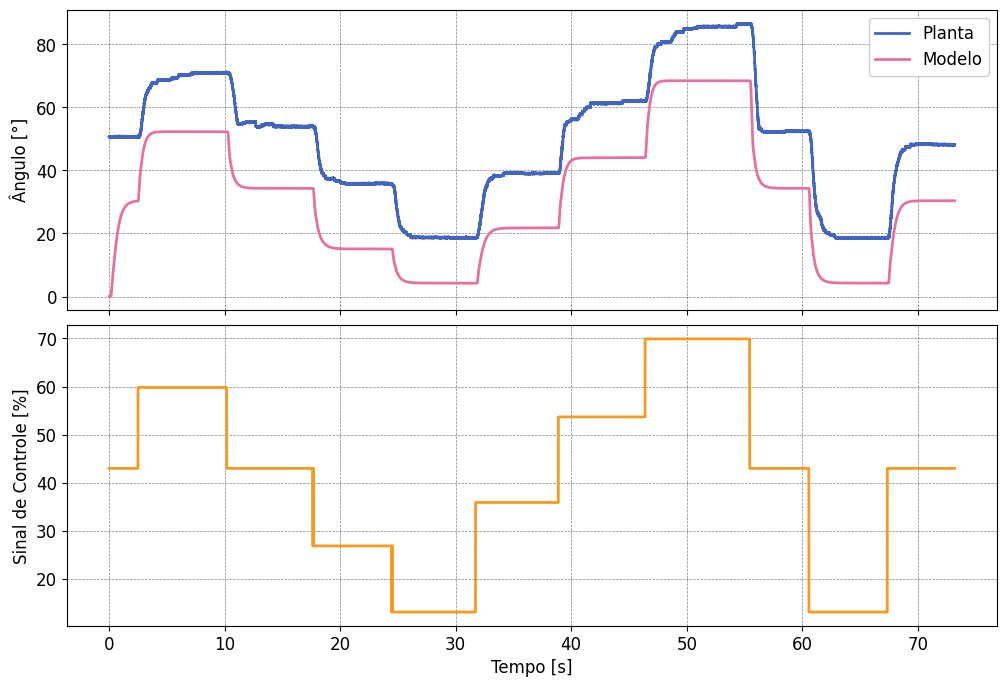

In [8]:
#Definição dos parâmetros do modelo:
fp = FANPLATE(
    La=8.73e-3,
    Ra=12,
    kaphi=1.57e-2,
    Jm=1.2e-5,
    Bm1=1.23e-5,
    Bm2=-3.45e-8,
    Bm3=6.42e-11,
    ku1=-8.98e-6,
    ku2=3.18e-7,
    ku3=-2.45e-10,
    Jp=4.8e-4/10,
    Bp0=1.4e-3,
    Bp1=1e-3,
    m=72e-3,
    g=9.81,
    l=68e-3
)

#Vetor de tempo:
#time = np.arange(0, 3, 1e-3)
time = degma[0]

#Vetor de sinal de controle:
#pwm = 100*np.ones(time.shape)
pwm = degma[3]

#Ângulo da planta:
ang = degma[1]

#Listas vazias para armazenar os dados:
th = [0]

#Loop de simulação discreta:
for i in range(1, len(time)):
    fp.model_update(pwm[i], (time[i]-time[i-1]))
    th.append(fp.th)

#Conversão dos dados:
th = np.degrees(np.array(th))

#Plot:
plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)
plt.subplot(2, 1, 1)
plt.plot(time, ang, label='Planta')
plt.plot(time, th, label='Modelo')
plt.ylabel('Ângulo [°]')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(time, pwm, color='C4')
plt.ylabel('Sinal de Controle [%]')
plt.xlabel('Tempo [s]')
plt.show()